In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

def load_simulation_data(M, T, rho, simJob):
    return np.load("../results-longrun-nohist/argon-M-%d-T-%.2f-rho-%.2f-simjob-%d.npz" % (M,T,rho,simJob))

Ms = [6]
Ts = np.linspace(0.25, 4.0, 16)
rhos = np.concatenate((np.array([0.02, 0.05]), np.linspace(0.1, 2.0, 20)))
simJobs = [0]

def calc_cv(K_block, n):
    delta_K_sq = np.var(K_block)
    K_sq = np.mean(K_block)**2

    C_v = 3 * K_sq / (2*K_sq - 3*n*delta_K_sq)
    return C_v

In [2]:
testData = load_simulation_data(6, 0.5, 1.2, 0)

In [3]:
corTime = 5.0
corSteps = int(corTime/testData["h"])
corBlocks = int(len(testData["temperature"]) / corSteps)

est_Ts = np.zeros((corBlocks))
est_CVs = np.zeros((corBlocks))

for i in range(0, corBlocks):
    est_Ts[i] = np.mean(testData["temperature"][i*corSteps:(i+1)*corSteps])
    est_CVs[i] = calc_cv(testData["kinetic_energy"][i*corSteps:(i+1)*corSteps], testData["n"])

In [4]:
est_Ts

array([ 0.49768599,  0.49751685,  0.49762157,  0.49744693,  0.4975602 ,
        0.49749448,  0.49772382,  0.49741449,  0.49772066,  0.49740626,
        0.49722901,  0.49753514])

(array([ 1.,  2.,  3.,  3.,  3.]),
 array([ 0.49722901,  0.49732797,  0.49742693,  0.49752589,  0.49762486,
         0.49772382]),
 <a list of 5 Patch objects>)

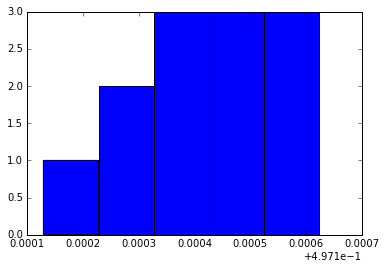

In [5]:
plt.hist(est_Ts, bins=5)

(array([ 3.,  4.,  2.,  2.,  1.]),
 array([ 2.40896924,  2.61551137,  2.8220535 ,  3.02859563,  3.23513776,
         3.44167989]),
 <a list of 5 Patch objects>)

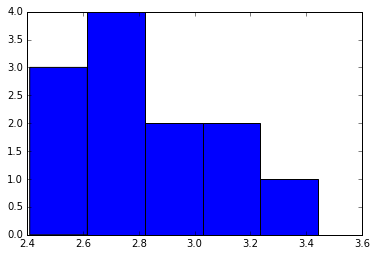

In [6]:
plt.hist(est_CVs, bins=5)

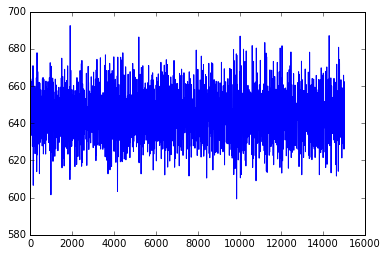

In [7]:
plt.plot(testData["kinetic_energy"])

In [8]:
est_CVs

array([ 2.81573656,  2.80239282,  2.55150157,  3.16802986,  2.60787577,
        2.83609058,  2.80063258,  2.79058487,  3.44167989,  3.19138476,
        2.40896924,  2.86476264])

In [9]:
testData["cv"]

array(2.831378645316229)

In [10]:
np.mean(est_CVs)

2.8566367616512611

In [11]:
np.std(est_CVs)/np.sqrt(corBlocks)

0.079899928747534377

In [12]:
est_CV_means = np.zeros((len(Ts), len(rhos), len(simJobs)))
est_CV_stds = np.zeros((len(Ts), len(rhos), len(simJobs)))

corTime = 5.0

for i in range(0, len(Ts)):
    for j in range(0, len(rhos)):
        for k in range(0, len(simJobs)):
            with load_simulation_data(6, Ts[i], rhos[j], simJobs[k]) as data:
                corSteps = int(corTime/data["h"])
                corBlocks = int(len(data["kinetic_energy"]) / corSteps)
                est_CVs = np.zeros((corBlocks))
                for l in range(0, corBlocks):
                    est_CVs[l] = calc_cv(data["kinetic_energy"][l*corSteps:(l+1)*corSteps], data["n"])
                    
                est_CV_means[i,j,k] = np.mean(est_CVs)
                est_CV_stds[i,j,k] = np.std(est_CVs) / np.sqrt(corBlocks)

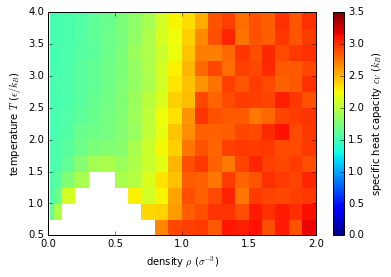

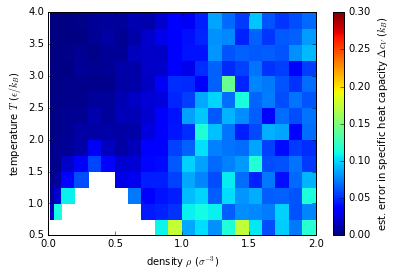

In [13]:
invMaskCV = est_CV_stds > 0.3
masked_cv = np.ma.masked_where(invMaskCV, est_CV_means)
masked_cv_std = np.ma.masked_where(invMaskCV, est_CV_stds)

plt.pcolor(rhos, Ts[1:], masked_cv[1:,:,0], vmin=0.0, vmax=3.5)
cbar = plt.colorbar(label="specific heat capacity $c_V$ ($k_B$)")
cbar.set_ticks(np.linspace(0,3.5,8))
plt.xlabel(r"density $\rho$ ($\sigma^{-3}$)")
plt.ylabel(r"temperature $T$ ($\epsilon / k_B$)")
#plt.savefig("longrun/cv-colorplot.png", dpi=300)


plt.figure()
plt.pcolor(rhos, Ts[1:], masked_cv_std[1:,:,0], vmin=0.0, vmax=0.3)
cbar = plt.colorbar(label="est. error in specific heat capacity $\Delta c_V$ ($k_B$)")
cbar.set_ticks(np.linspace(0,0.3,7))
plt.xlabel(r"density $\rho$ ($\sigma^{-3}$)")
plt.ylabel(r"temperature $T$ ($\epsilon / k_B$)")
#plt.savefig("longrun/cv-colorplot-stds.png", dpi=300)

In [14]:
np.max(masked_cv_std)

0.22190242557399564

In [15]:
def calc_press(temp, virial, n, rho):
    T_block = np.mean(temp)
    return (1 + 1/(3 * n * T_block) * np.mean(virial)) * rho * T_block

In [16]:
est_P_means = np.zeros((len(Ts), len(rhos), len(simJobs)))
est_P_stds = np.zeros((len(Ts), len(rhos), len(simJobs)))

corTime = 5.0

for i in range(0, len(Ts)):
    for j in range(0, len(rhos)):
        for k in range(0, len(simJobs)):
            with load_simulation_data(6, Ts[i], rhos[j], simJobs[k]) as data:
                corSteps = int(corTime/data["h"])
                corBlocks = int(len(data["virial"]) / corSteps)
                est_P = np.zeros((corBlocks))
                for l in range(0, corBlocks):
                    est_P[l] = calc_press(data["temperature"][l*corSteps:(l+1)*corSteps], data["virial"][l*corSteps:(l+1)*corSteps], data["n"], data["rho"])
                    
                est_P_means[i,j,k] = np.mean(est_P)
                est_P_stds[i,j,k] = np.std(est_P) / np.sqrt(corBlocks)

/Users/jesse/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10


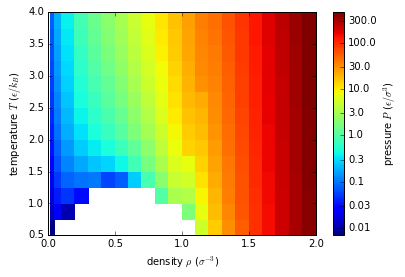

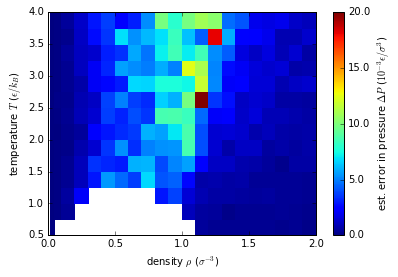

In [17]:
#invMaskCV = est_CV_stds > 0.3
invMaskP = np.array(est_P_means < 0.0, dtype=bool) | np.array(est_P_stds / est_P_means > 0.1, dtype=bool)
masked_P = np.ma.masked_where(invMaskP, est_P_means)
masked_P_std = np.ma.masked_where(invMaskP, est_P_stds)

plt.pcolor(rhos, Ts[1:], np.log10(masked_P[1:,:,0]))
cbar = plt.colorbar(label="pressure $P$ ($\epsilon / \sigma^3$)")
tickrange = [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0]
cbar.set_ticks(np.log10(tickrange))
cbar.set_ticklabels(tickrange)
plt.xlabel(r"density $\rho$ ($\sigma^{-3}$)")
plt.ylabel(r"temperature $T$ ($\epsilon / k_B$)")
#plt.savefig("longrun/pressure-colorplot.png", dpi=300)


plt.figure()
plt.pcolor(rhos, Ts[1:], masked_P_std[1:,:,0], vmin=0.0, vmax=0.02)
cbar = plt.colorbar(label="est. error in pressure $\Delta P$ ($10^{-3} \epsilon / \sigma^3$)")
cbar.set_ticks(np.linspace(0,0.02,5))
cbar.set_ticklabels(np.linspace(0,0.02,5)*1000)
plt.xlabel(r"density $\rho$ ($\sigma^{-3}$)")
plt.ylabel(r"temperature $T$ ($\epsilon / k_B$)")
#plt.savefig("longrun/pressure-colorplot-stds.png", dpi=300)

0.7
0.8
0.9
1.0
1.1
1.2


/Users/jesse/anaconda/lib/python3.5/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


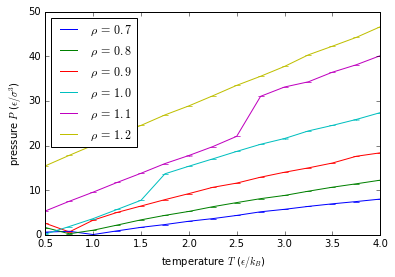

In [33]:
r = 11
for r in range(8,14):
    print(rhos[r])
    plt.plot(Ts[1:], np.abs(est_P_means[1:,r]), label=r"$\rho\, =\, " + str(rhos[r]) + "$")
    
plt.gca().set_color_cycle(None)
for r in range(8,14):
    plt.errorbar(Ts[1:], np.abs(est_P_means[1:,r]), yerr=est_P_stds[1:,r], linestyle="None")
plt.legend(loc=2)
plt.xlabel(r"temperature $T$ ($\epsilon / k_B$)")
plt.ylabel(r"pressure $P$ ($\epsilon / \sigma^{3}$)")

plt.savefig("longrun/pressure-rhos.png", dpi=300)

# plt.plot(Ts[1:], rhos[11] * Ts[1:], linewidth=3)
#plt.ylim(0,2.5)
# plt.savefig("longrun/diffusion-coefficients-rhos.png", dpi=300)

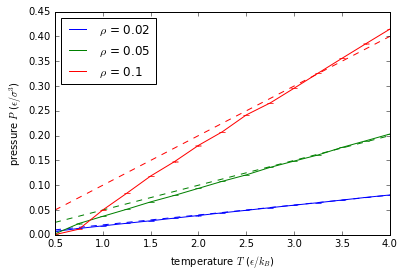

In [54]:
for r in range(0,3):
    a = plt.plot(Ts[1:], np.abs(est_P_means[1:,r]), label=r"$\rho$ = " + str(rhos[r]))
    plt.plot(Ts[1:], rhos[r]*Ts[1:], color=a[0].get_color(), linestyle="dashed")
    plt.errorbar(Ts[1:], np.abs(est_P_means[1:,r]), yerr=est_P_stds[1:,r], color=a[0].get_color(), linestyle="None")

plt.legend(loc=2)
plt.xlabel(r"temperature $T$ ($\epsilon / k_B$)")
plt.ylabel(r"pressure $P$ ($\epsilon / \sigma^{3}$)")

plt.savefig("longrun/pressure-gas-rhos.png", dpi=300)

# plt.plot(Ts[1:], rhos[11] * Ts[1:], linewidth=3)
#plt.ylim(0,2.5)
# plt.savefig("longrun/diffusion-coefficients-rhos.png", dpi=300)

In [50]:
a[0].get_color()

'b'